## Homework 1
Bartłomiej Eljasiak, Tomasz Krupiński, Dominik Pawlak

# Important note !!!
In order to run this notebook yourself you have to put it inside [this](https://github.com/wangshuocas/COVID-19) respository, inside ERSCOVIDTest folder.

#### Used libraries

In [1]:
import scipy.io
%matplotlib notebook

import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from time import sleep

import csv
import os

# Main goal of this paper
### Introduce automated way of classifing COVID-19 patients into low and high risk groups based on lung CT scans

# Contents 
 - ### Lung segmentation on CT scans without contrast
 - ### Distinguishing patients with different types of pneumonia, from COVID-19 patients

## Steps
### 1. Lung segmentation
     Authors used DenseNet121-FPN model pretrained on ImageNet and later fined tuned on VESSEL12
- 1 From 512x512 px CT scans saved in .mat files extract 256x256 px lung mask
- 2 Apply mask in order to get 240x360 px zoomed lung images
- 3 Those images can be used to classify patient 
        
### 2. COVID-19 patients classification
    This was achieved using COVID-19Net model pretrained to predict EGFR mutations on large  CT-EGFR  dataset, and later fine tuned on COVID-19 dataset to specifically  mine  lung  characteristics  associated  with  17 COVID-19. The output of this model is probability  of  the  input  patient  being  19 infected with COVID-19, but if the result is possitive at the same time affiliation to low and high risk group was calculated.
- 1 Using zoomed lung scan predict COVID-19 propability
- 2 If positive, use model features and extra clinical features to create prognose

## Dataset description

The only photos we have, are the ones from validation sets. There are CT photos of 12 chests, the size of 512, 512, x; the same photos with lung masks, the size of 256, 256, x; and the most crucial: the photos of zoomed lung masks, the size of 340, 240, 48 each. The "x" means, that this variable was not constant, it was from around 40 to around 500. All photos have .mat extension. The model itself learned from zoomed lung masks, therefore those will be the only ones, we analyse closer. 

In [2]:
files = ['sampleData/validation1.csv', 'sampleData/validation2.csv']

for f in files:
    with open(f) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            img = scipy.io.loadmat(row[0][3:])
            x = np.min(img['only_lung_zoomed_3std'])
            y = np.max(img['only_lung_zoomed_3std'])
            print("shape: ",img['only_lung_zoomed_3std'].shape,"size:", os.stat(row[0][3:]).st_size,"B min:", x,"max:", y)

shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 333.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 237.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 265.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 284.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 228.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 202.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 197.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 290.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 208.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 269.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 210.0
shape:  (240, 360, 48) size: 33177816 B min: -1024.0 max: 175.0


As you see, all photos have identical measurements, sizes and numbers of bits per pixel.
* Measurements: 240 x 360 x 48
* Size: 33 177 816 B
* Number of bits per pixel: log_2(1024 + 1024) = 11


# 2. Data collecting

The data included two datasets: COVID-19 dataset (n=1266) and CT-EGFR dataset (n=4106).

There was a proposed a two-step transfer learning process. The first step was to use large CT-EGFR dataset to  train the COVID-19Net to predict EGFR mutation status.

The CT-EGFR dataset consisted of 4106 patients with lung cancer who met the following criteria: 
* epidermal growth factor receptor (EGFR) gene sequencing was obtained; 
* non-contrast enhanced chest CT data obtained within 4 weeks before EGFR gene sequencing. 
The CT-EGFR dataset was used for auxiliary training of the DL system, making the DL system learn lung features automatically.

In the second training process the COVID-19 dataset was used.

The COVID-19 dataset included patients who met the following criteria:
* RT-PCR confirmed COVID-19; 
* lab-confirmed other types of pneumonia before Dec. 2019; 
* have non-contrast enhanced chest CT at diagnosis time.

In the COVID-19 dataset; patients from Wuhan city and Henan province formed the training set (n=709); patients from Anhui province formed the external validation set 1 (n=226); patients from Heilongjiang province formed the validation set 2 (n=161); patients from Beijing formed the validation set 3 (n=53); patients from Huangshi city formed the validation set 4 (n=117).

The training set was used to train the proposed DL system; the validation set 1 and 2 were used to evaluate the diagnostic performance of the DL system; and the validation set 3 and 4 were used for evaluating the prognostic performance of the DL system.



![X](https://www.medrxiv.org/content/medrxiv/early/2020/03/26/2020.03.24.20042317/F1.large.jpg?width=800&height=600&carousel=1)


# 3. Data balancing

The authors came across data imbalance when in the second training process, but didn't write about it in the article, but in attached document "Supplementary Methods", in which they described all mathematical details of the neural networks.

"Due to the imbalance between the number of COVID-19 and other pneumonia, we used a class weight where the loss weight of COVID-19 was 1, and the loss weight of other pneumonia was 7."

Unfortunately, the authors did not share the code of this process.

The "class weigh" method is to give more weightage to the minority class in the cost function of the algorithm so that it could provide a higher penalty to the minority class and the algorithm could focus on reducing the errors for the minority class (during training). This can be achieved by giving different weights to both the majority and minority classes. The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

To see more details visit: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

## Creating masks
Classification model proposed by the author uses zooomed lung scans, that were created by additional DL model DenseNet121-FPN, which was pretrained on 1.4 milion natural images from ImageNet and later fined tuned on VESSEL12 dataset. Let's go through steps of creting such a mask

First of let's import raw scan

In [3]:
CT_scan = scipy.io.loadmat("sampleData/validation1/67batch52_L0/67batch52_L0.mat")

This is a dirctory containg 4 objects, but only the last is importnat to us

In [4]:
CT_scan.keys()

dict_keys(['__header__', '__version__', '__globals__', 'new_img'])

In [5]:
CT_scan['new_img'].shape

(512, 512, 48)

This is a 512x512px image with 48 layers that make whole 3D scan. Let's see an example of this

<IPython.core.display.Javascript object>


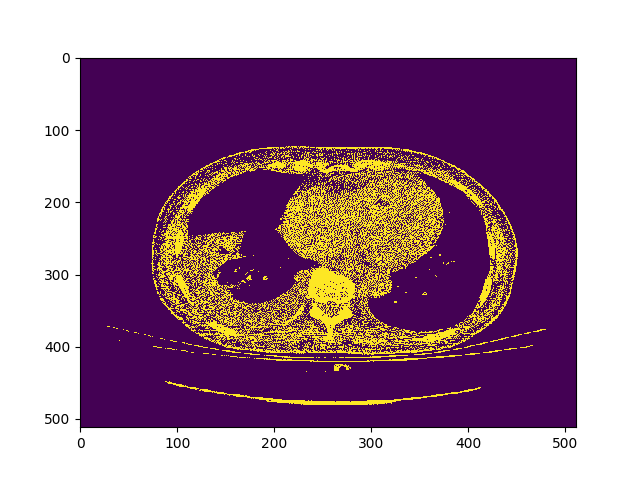

In [6]:
plt.imshow(CT_scan['new_img'][:,:,13], interpolation='none', aspect='auto', vmin=0, vmax=1)

But we want to have a way into looking at whole 3D scan. We will use animation to inspect layers of scans

In [7]:
def create_animation(data, interval = 150, show = True, filename = None):
    fig = plt.figure( figsize=(8,8) )
    init_frame = data[:,:,0]
    im = plt.imshow(init_frame, interpolation='none', aspect='auto', vmin=0, vmax=1)

    def animate_func(i):
        im.set_array(data[:,:,i])
        return [im]

    frames = data.shape[2]
    
    anim = animation.FuncAnimation(fig, animate_func, frames = frames,interval = interval, blit = True)    
    return anim

<IPython.core.display.Javascript object>


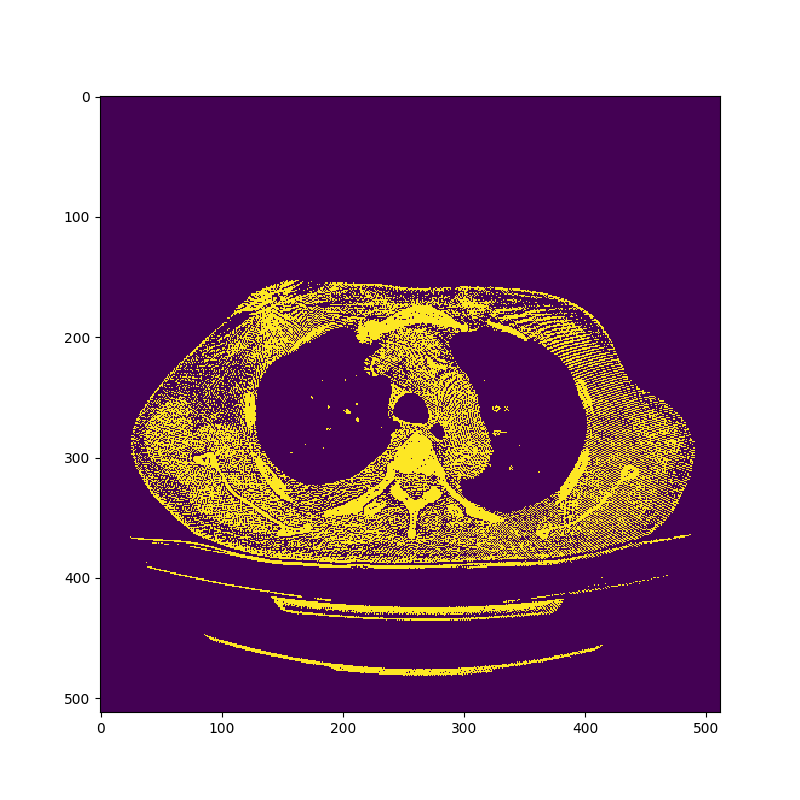

In [8]:
create_animation(CT_scan['new_img'])

Another example

In [9]:
CT_scan_2 = scipy.io.loadmat("sampleData/validation1/20002788_L1/20002788_L1.mat")

In [10]:
CT_scan_2['new_img'].shape

(512, 512, 42)

This time we have only 42 layers

<IPython.core.display.Javascript object>


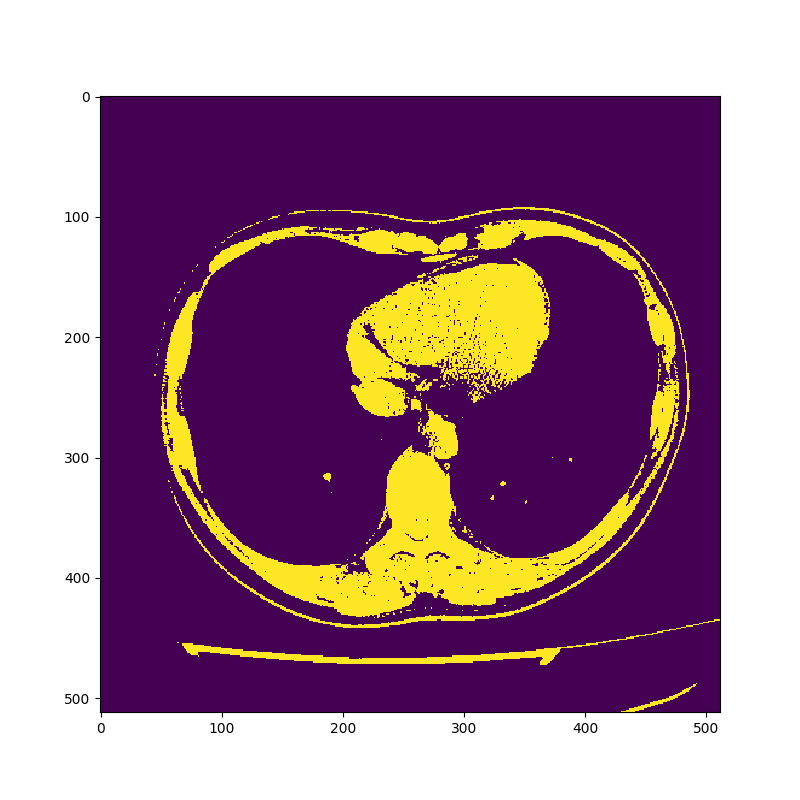

In [11]:
create_animation(CT_scan_2['new_img'])

### Closer look at created masks

In [12]:
lung_mask_1 = scipy.io.loadmat("sampleData/validation1/20002788_L1/20002788_L1_lungMask.mat")
lung_mask_1["lung_mask"].shape

(256, 256, 40)

What's interesting the type of data that those scans were stored in changed as well, but since mask is result of DL model this is expected

In [13]:
CT_min = np.min(CT_scan_2['new_img'])
CT_max =np.max(CT_scan_2['new_img'])
mask_min = np.min(lung_mask_1["lung_mask"])
mask_max =np.max(lung_mask_1["lung_mask"])
print(f"CT scans 'color' value range [{CT_min},{CT_max}]")
print(f"CT mask 'color' value range [{mask_min},{mask_max}]")

CT scans 'color' value range [-2048,2028]
CT mask 'color' value range [0.0,1.0]


Ok so we can right away see that masks have a different shape. Not only was the resolution reduced 2 times, but we lost some  of the layers (2 in this example), this is due to the fact that they did not contain lung data

<IPython.core.display.Javascript object>


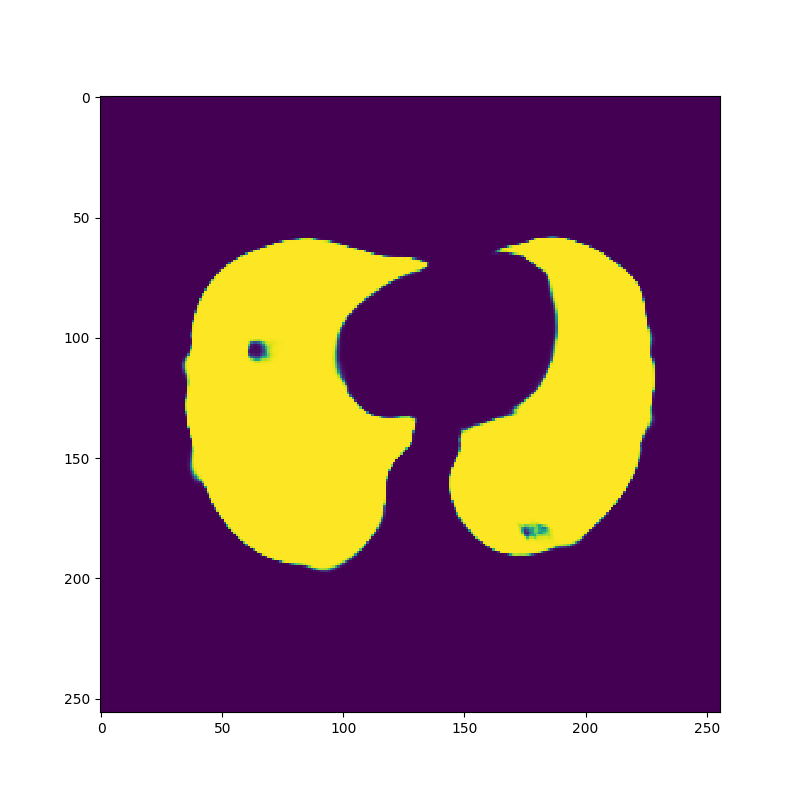

In [14]:
create_animation(lung_mask_1["lung_mask"])

### Let's apply the mask to the image

First of all we have to make it larger, to match the oryginal scan

In [15]:
resized_mask = np.repeat(np.repeat(lung_mask_1["lung_mask"], 2, axis=0), 2, axis=1)

In [16]:
resized_mask.shape

(512, 512, 40)

Let add two missing layers, at the end, because after closer inspection it's clear that they were removed

In [17]:
resized_mask = np.append(resized_mask, np.zeros((512,512,2)),axis = 2)

In [18]:
resized_mask.shape

(512, 512, 42)

Then we want to fiter all data of oryginal scan if it's not present in the mask

In [27]:
CT_scan_2_masked = np.where(resized_mask>0,CT_scan_2['new_img'], 0)

And now we can display the mask on oryginal scan

<IPython.core.display.Javascript object>


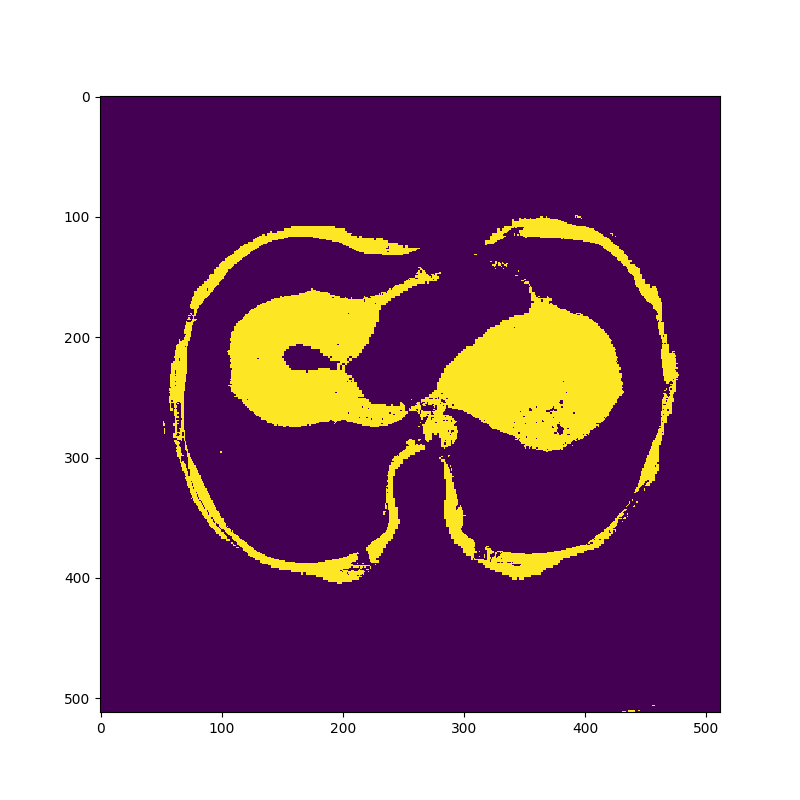

In [28]:
create_animation(CT_scan_2_masked)

### Zoomed lungs data

The result of this whole process should be zoomed image of lungs scans where allmost all data contained in the matrix describes lungs. As authors mentioned there were some leftovers but classification model was not interested in them and in the end focused on parts of lungs essential to COVID-19

In [21]:
lung_mask_zoomed_1 = scipy.io.loadmat("sampleData/validation1/20002788_L1/20002788_L1_onlyLungZoomed3std.mat")

In [22]:
lung_mask_zoomed_1['only_lung_zoomed_3std'].shape

(240, 360, 48)

Authors decided to further reshape the data, but now this shape is constant within all scans. This is of course due to the fact that these images will be used to feed DL model in the second part of the authors work which is low-high risk patient classification.

This is the result of our preparation process

<IPython.core.display.Javascript object>


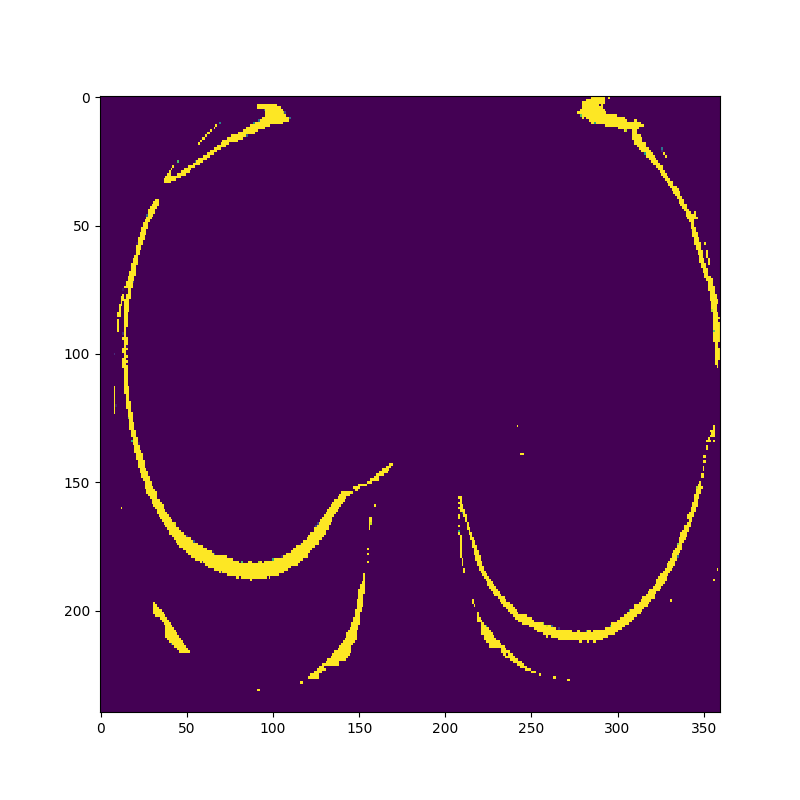

In [29]:
create_animation(lung_mask_zoomed_1['only_lung_zoomed_3std'])

And another example

In [31]:
lung_mask_zoomed_2 = scipy.io.loadmat("sampleData/validation1/G116877_L1/G116877_L1_onlyLungZoomed3std.mat")

<IPython.core.display.Javascript object>


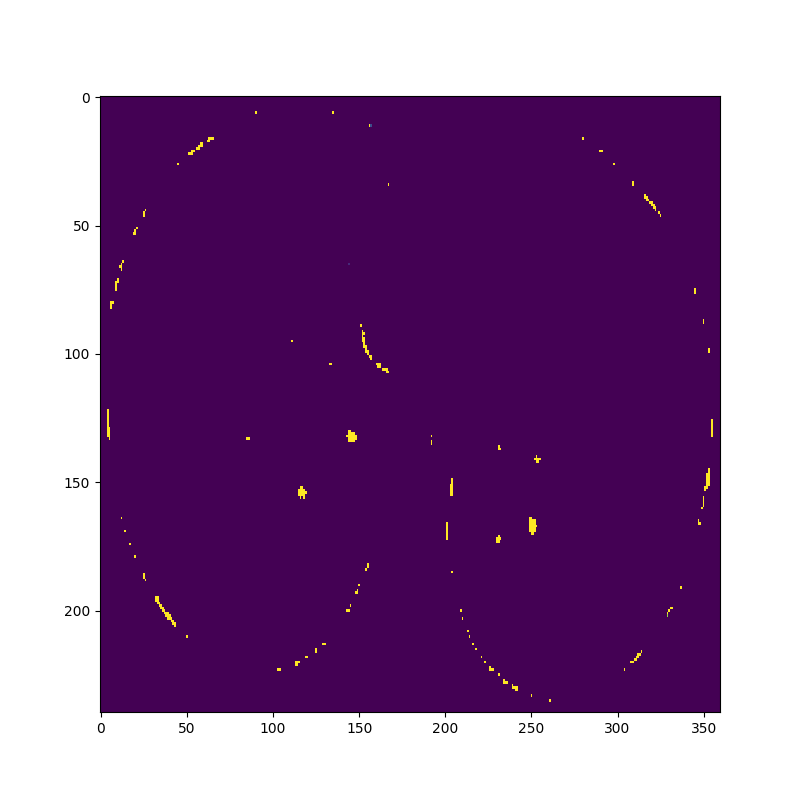

In [33]:
create_animation(lung_mask_zoomed_2['only_lung_zoomed_3std'])

This is suprisng, but with such a dataset authors were able to distinguish COVID-19 from pneumonia with AUC = 0.86, and with extra clinical features deretmine with high accuracy if the patient is in low or hight risk group.